In [1]:
import numpy        as np
import pandas       as pd

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/global_temperature_time_series.csv')

In [3]:
df['Source'].unique()

array(['gcag', 'GISTEMP'], dtype=object)

In [4]:
df.head()

,Source,Year,Mean
0,gcag,1850-01,-0.6746
1,gcag,1850-02,-0.3334
2,gcag,1850-03,-0.5913
3,gcag,1850-04,-0.5887
4,gcag,1850-05,-0.5088


In [5]:
df['time'] = pd.to_datetime(df['Year'])

In [6]:
df = df.drop(columns=['Source', 'Year']).rename(columns={'Mean': 'temperature'})

In [7]:
df.head()

,temperature,time
0,-0.6746,1850-01-01
1,-0.3334,1850-02-01
2,-0.5913,1850-03-01
3,-0.5887,1850-04-01
4,-0.5088,1850-05-01


In [8]:
df.tail()

,temperature,time
3818,1.2515,2024-03-01
3819,1.2053,2024-04-01
3820,1.0745,2024-05-01
3821,1.1154,2024-06-01
3822,1.1398,2024-07-01


In [9]:
class LagTimeFeaturesCreator:

    def __init__(self, windows=[2, 3, 4], functions=["mean", "median", "max", "min"]):

        self.windows = windows
        self.functions = functions

    def _create_lag_one(self):

        self.df['lag_one'] = self.df[self.target].shift(1) # lag de um período

    def _calc_mean(self):

        for win in self.windows:
            self.df[f'{self.target}_mean_{win}_lag'] = self.df['lag_one'].rolling(window=win).mean()

    def _calc_median(self):

        for win in self.windows:
            self.df[f'{self.target}_median_{win}_lag'] = self.df['lag_one'].rolling(window=win).median()

    def _calc_sum(self):

        for win in self.windows:
            self.df[f'{self.target}_sum_{win}_lag'] = self.df['lag_one'].rolling(window=win).sum()

    def _calc_max(self):

        for win in self.windows:
            self.df[f'{self.target}_max_{win}_lag'] = self.df['lag_one'].rolling(window=win).max()

    def _calc_min(self):

        for win in self.windows:
            self.df[f'{self.target}_min_{win}_lag'] = self.df['lag_one'].rolling(window=win).min()

    def _calc_std(self):

        for win in self.windows:
            self.df[f'{self.target}_std_{win}_lag'] = self.df['lag_one'].rolling(window=win).std()
    
    def _calc_diff(self):

        for win in self.windows:
            self.df[f'{self.target}_diff_{win}_lag'] = self.df['lag_one'].rolling(window=win).apply(lambda x: x.max() - x.min())

    def _calc_kurt(self):

        for win in self.windows:
            self.df[f'{self.target}_kurt_{win}_lag'] = self.df['lag_one'].rolling(window=win).kurt()

    def _calc_skew(self):

        for win in self.windows:
            self.df[f'{self.target}_skew_{win}_lag'] = self.df['lag_one'].rolling(window=win).skew()

    def _calc_slope(self, y):

        x = np.arange(len(y))  # Índices como variável independente (tempo)
        slope = np.polyfit(x, y, deg=1)[0]  # Grau 1 = regressão linear
        return slope
    
    def _calc_slope_win(self):

        for win in self.windows:
            self.df[f'{self.target}_slope_{win}_lag'] = self.df['lag_one'].rolling(window=win).apply(calc_slope, raw=True)

    def _apply_functions(self):

        self._create_lag_one()
        
        for func in self.functions:

            match func:

                case "mean":

                    self._calc_mean()

                case "median":

                    self._calc_median()

                case "sum":

                    self._calc_sum()

                case "max":

                    self._calc_max()

                case "min":

                    self._calc_min()

                case "std":

                    self._calc_std()

                case "diff":

                    self._calc_diff()

                case "kurt":

                    self._calc_kurt()

                case "skew":

                    self._calc_skew()

                case "slope":

                    self._calc_slope_win()

    def calculate(self, df, target):
        
        self.df = df
        self.target = target
        
        self._apply_functions()
        
        return self.df

In [10]:
l = LagTimeFeaturesCreator()
df1 = l.calculate(df, target='temperature')

In [11]:
df1.head()

,temperature,time,lag_one,temperature_mean_2_lag,temperature_mean_3_lag,temperature_mean_4_lag,temperature_median_2_lag,temperature_median_3_lag,temperature_median_4_lag,temperature_max_2_lag,temperature_max_3_lag,temperature_max_4_lag,temperature_min_2_lag,temperature_min_3_lag,temperature_min_4_lag
0,-0.6746,1850-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.3334,1850-02-01,-0.6746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.5913,1850-03-01,-0.3334,-0.50400,NaN,NaN,-0.50400,NaN,NaN,-0.3334,NaN,NaN,-0.6746,NaN,NaN
3,-0.5887,1850-04-01,-0.5913,-0.46235,-0.533100,NaN,-0.46235,-0.5913,NaN,-0.3334,-0.3334,NaN,-0.5913,-0.6746,NaN
4,-0.5088,1850-05-01,-0.5887,-0.59000,-0.504467,-0.547,-0.59000,-0.5887,-0.59,-0.5887,-0.3334,-0.3334,-0.5913,-0.5913,-0.6746


In [12]:
X = df1.drop(columns=['time', 'temperature'])
y = df1[['temperature']]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.5, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
X_train.shape

(1911, 13)

In [14]:
X_valid.shape

(956, 13)

In [15]:
X_test.shape

(956, 13)

In [16]:
# import shap
# import optuna

# import pandas  as pd
# import seaborn as sns

# import matplotlib.pyplot as plt

# from typing   import List, Dict
# from sklearn  import metrics
# from lightgbm import LGBMRegressor

# from sklearn.model_selection import train_test_split


# class AutoMLLightGBMRegressor:
    
#     def __init__(
#         self, X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, 
#         X_test: pd.DataFrame, y_test: pd.DataFrame, best_features: list[str], target: str, n_trials: int = 50, random_state: int = 42):

#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_valid = X_valid
#         self.y_valid = y_valid
#         self.X_test = X_test
#         self.y_test = y_test
#         self.best_features = best_features
#         self.target = target
#         self.n_trials = n_trials
#         self.random_state = random_state

#     def _get_metrics(self, y: pd.DataFrame, pred_col: str) -> dict[str, float]:
        
#         y_true = y[self.target]
#         y_pred = y[pred_col]
        
#         return {
#             'R2': metrics.r2_score(y_true, y_pred),
#             'MAE': metrics.mean_absolute_error(y_true, y_pred),
#             'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
#             'RMSE': metrics.root_mean_squared_error(y_true, y_pred),
#             'Explained Variance': metrics.explained_variance_score(y_true, y_pred)
#         }

#     def _train_model(self, model_name: str, features: list[str], model: LGBMRegressor) -> tuple[LGBMRegressor, dict[str, dict[str, float]]]:
        
#         model.fit(
#             self.X_train[features], self.y_train[self.target],
#             eval_set=[(self.X_valid[features], self.y_valid[self.target])]
#         )

#         self.y_train[f'{model_name}_pred'] = model.predict(self.X_train[features])
#         self.y_valid[f'{model_name}_pred'] = model.predict(self.X_valid[features])
#         self.y_test[f'{model_name}_pred'] = model.predict(self.X_test[features])

#         results = {
#             'Train': self._get_metrics(self.y_train, f'{model_name}_pred'),
#             'Valid': self._get_metrics(self.y_valid, f'{model_name}_pred'),
#             'Test': self._get_metrics(self.y_test, f'{model_name}_pred'),
#         }
        
#         return model, results
    
#     def _plot_feature_impotance(self, model: LGBMRegressor) -> None:

#         df_imp = pd.DataFrame(model.feature_importances_, model.feature_name_).reset_index()
#         df_imp.columns = ["Variable", "Importance"]
#         df_imp = df_imp.sort_values("Importance", ascending=False)
    
#         sns.barplot(x="Importance", y="Variable", color="#006e9cff", data=df_imp[:20])
    
#         plt.title(f"Importance of Variables")
#         plt.show()

#     def _plot_shap_summary(self, model: LGBMRegressor) -> None:

#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(self.X_train[model.feature_name_])
#         shap.summary_plot(shap_values, X_train[model.feature_name_])

#     def _plot_residuals(self, y: pd.DataFrame, pred_col: str, title: str) -> None:
        
#         residuals = y[self.target] - y[pred_col]
        
#         sns.histplot(residuals, kde=True)
        
#         plt.title(f"Distribuição dos Resíduos - {title}")
#         plt.xlabel("Erro (y_true - y_pred)")
#         plt.show()

#     def _plot_pred_vs_true(self, y: pd.DataFrame, pred_col: str, title: str) -> None:
    
#         sns.scatterplot(x=y[self.target], y=y[pred_col])
    
#         plt.plot([y[self.target].min(), y[self.target].max()], [y[self.target].min(), y[self.target].max()], '--r')
#         plt.xlabel("y_true")
#         plt.ylabel("y_pred")
#         plt.title(f"y_true vs y_pred - {title}")
#         plt.show()

#     def _error_by_quantile(self, y: pd.DataFrame, pred_col: str, title: str) -> None:
        
#         y_copy = y.copy()
#         y_copy["quantile"] = pd.qcut(y_copy[self.target], q=5)
#         y_copy["abs_error"] = abs(y_copy[self.target] - y_copy[pred_col])
    
#         sns.boxplot(x="quantile", y="abs_error", data=y_copy)
    
#         plt.title(f"Erro absoluto por quantil do target - {title}")
#         plt.xticks(rotation=45)
#         plt.show()

#     def _plot_shap_dependence(self, model: LGBMRegressor) -> None:
    
#         explainer = shap.TreeExplainer(model)
#         shap_values = explainer.shap_values(self.X_train[model.feature_name_])
        
#         for feature in model.feature_name_[:3]:  # top 3 features
#             shap.dependence_plot(feature, shap_values, self.X_train[model.feature_name_])

#     def _train_base_model(self) -> dict[str, dict[str, float]]:
        
#         model = LGBMRegressor(random_state=self.random_state)
        
#         return self._train_model('base_model', self.X_train.columns.tolist(), model)

#     def _train_best_feature_model(self) -> dict[str, dict[str, float]]:
        
#         model = LGBMRegressor(random_state=self.random_state)
        
#         return self._train_model('best_feature_model', self.best_features, model)

#     def _summarize_metric_results(self, results: dict[str, dict[str, float]]) -> pd.DataFrame:
        
#         rows = []
    
#         for dataset, metrics_dict in results.items():
#             row = {"Dataset": dataset}
#             row.update(metrics_dict)
#             rows.append(row)
    
#         return pd.DataFrame(rows)

#     def _get_best_params(self) -> dict:
        
#         def objective(trial):
            
#             params = {
#                 'objective': 'regression',
#                 'metric': 'rmse',
#                 'boosting_type': 'gbdt',
#                 'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#                 'max_depth': trial.suggest_int('max_depth', 3, 15),
#                 'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
#                 'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
#                 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#                 'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#                 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#                 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#                 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#                 'random_state': self.random_state,
#                 'verbose': -1,
#             }
            
#             model = LGBMRegressor(**params)
#             model.fit(
#                 self.X_train[self.best_features], self.y_train[self.target],
#                 eval_set=[(self.X_valid[self.best_features], self.y_valid[self.target])],
#             )
            
#             preds = model.predict(self.X_valid[self.best_features])
            
#             return metrics.r2_score(self.y_valid[self.target], preds)

#         optuna.logging.set_verbosity(optuna.logging.WARNING)
        
#         study = optuna.create_study(direction='maximize')
#         study.optimize(objective, n_trials=self.n_trials)
        
#         return study.best_params

#     def _train_best_params_model(self) -> dict[str, dict[str, float]]:
        
#         best_params = self._get_best_params()
#         self.best_params_model = LGBMRegressor(**best_params)
        
#         return self._train_model('best_params_model', self.best_features, self.best_params_model)

#     def _analyze_model(self, model_name: str, model: LGBMRegressor, results: dict[str, dict[str, float]]) -> None:
        
#         print(f"{model_name} Results")
    
#         display(self._summarize_metric_results(results))

#         pred_col = f"{model_name}_pred"
#         self._plot_residuals(self.y_test, pred_col, f"{model_name} (Test Dataset)")
#         self._plot_pred_vs_true(self.y_test, pred_col, f"{model_name} (Test Dataset)")
#         self._error_by_quantile(self.y_test, pred_col, f"{model_name} (Test Dataset)")
#         self._plot_feature_impotance(model)
#         self._plot_shap_summary(model)
#         self._plot_shap_dependence(model)

#     def train(self) -> None:
        
#         self.base_model, self.base_model_results = self._train_base_model()
#         self.best_feature_model, self.best_feature_model_results = self._train_best_feature_model()
#         self.best_params_model, self.best_params_model_results = self._train_best_params_model()

#     def summarize_metrics(self) -> pd.DataFrame:

#         model_results = {
#             "Base Model": self.base_model_results,
#             "Best Feature Model": self.best_feature_model_results,
#             "Best Params Model": self.best_params_model_results,
#         }

#         summary_frames = [self._summarize_metric_results(results).assign(Model=name) for name, results in model_results.items()]

#         return pd.concat(summary_frames, ignore_index=True)
    
#     def get_model_analysis(self) -> None:
    
#         self._analyze_model("base_model", self.base_model, self.base_model_results)
#         self._analyze_model("best_feature_model", self.best_feature_model, self.best_feature_model_results)
#         self._analyze_model("best_params_model", self.best_params_model, self.best_params_model_results)


In [17]:
from dstoolkit.models import AutoMLLightGBMRegressor as AutoMLLightGBMRegressor_

/home/junior/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
a = AutoMLLightGBMRegressor_(
    X_train, y_train, X_valid, y_valid, X_test, y_test,  target='temperature', n_trials=50,
    best_features=['lag_one', 'temperature_mean_2_lag', 'temperature_mean_3_lag',	'temperature_mean_4_lag', 'temperature_median_2_lag',	'temperature_median_3_lag']
)

In [19]:
a.train()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 1911, number of used features: 13
[LightGBM] [Info] Start training from score 0.001615
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1911, number of used features: 6
[LightGBM] [Info] Start training from score 0.001615


In [20]:
a.summarize_metrics()

,Dataset,R2,MAE,MAPE,RMSE,Explained Variance,Model
0,Train,0.973372,0.051009,9.475819e+11,0.066983,0.973372,Base Model
1,Valid,0.920705,0.085225,1.108280e+11,0.114455,0.920813,Base Model
2,Test,0.910944,0.083374,2.595298e+12,0.115218,0.911093,Base Model
3,Train,0.965235,0.058090,1.153450e+12,0.076537,0.965235,Best Feature Model
4,Valid,0.920477,0.084742,6.434529e+10,0.114619,0.920687,Best Feature Model
5,Test,0.911942,0.083496,2.481403e+12,0.114571,0.912021,Best Feature Model
6,Train,0.954619,0.066308,1.283719e+12,0.087445,0.954619,Best Params Model
7,Valid,0.922221,0.083669,8.700930e+10,0.113356,0.922392,Best Params Model
8,Test,0.912281,0.083189,2.484006e+12,0.114350,0.912337,Best Params Model


base_model Results


,Dataset,R2,MAE,MAPE,RMSE,Explained Variance
0,Train,0.973372,0.051009,9.475819e+11,0.066983,0.973372
1,Valid,0.920705,0.085225,1.108280e+11,0.114455,0.920813
2,Test,0.910944,0.083374,2.595298e+12,0.115218,0.911093


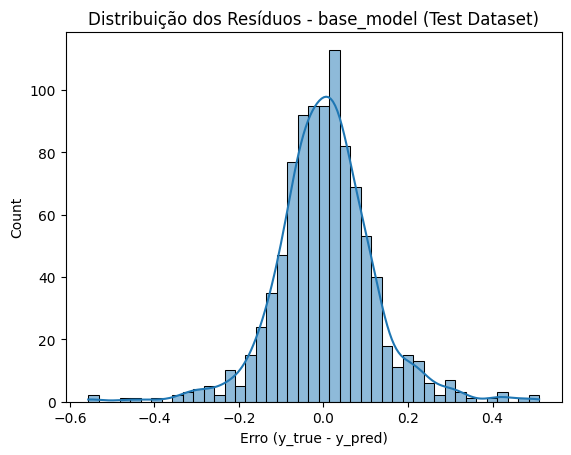

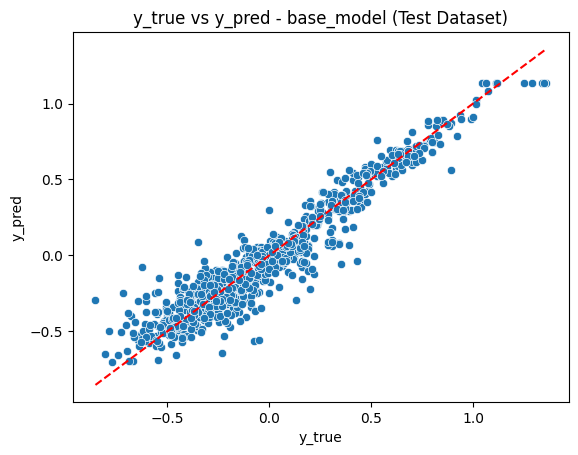

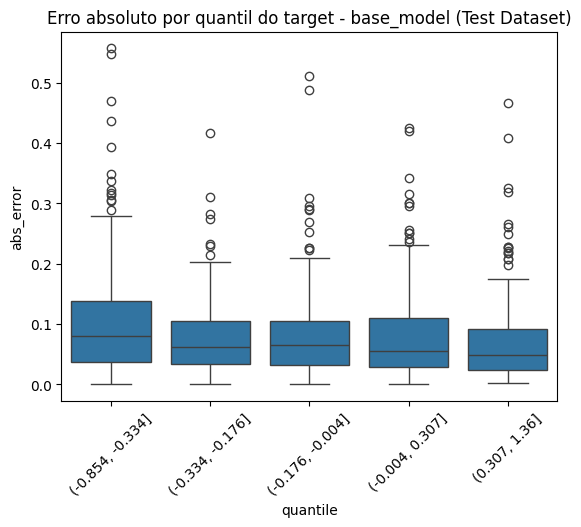

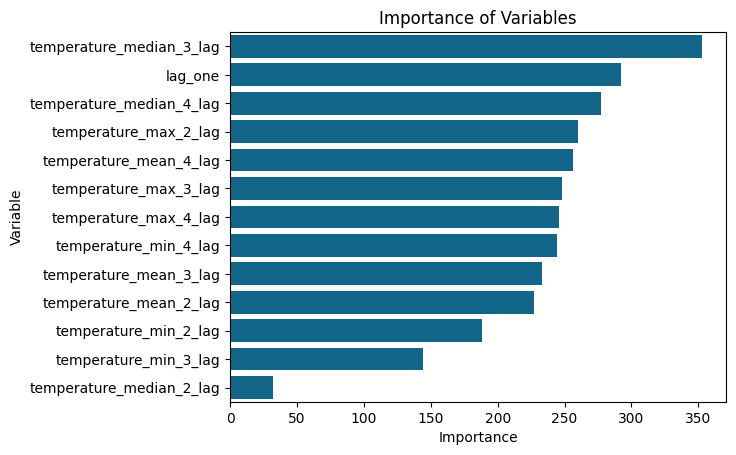

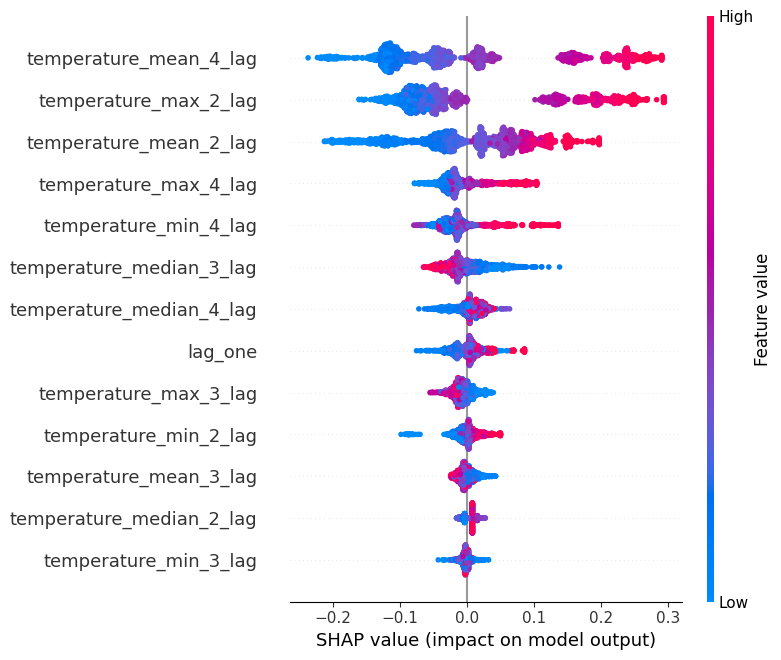

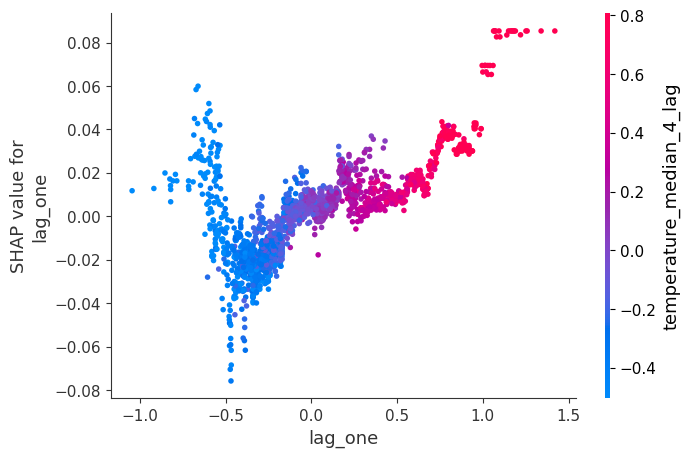

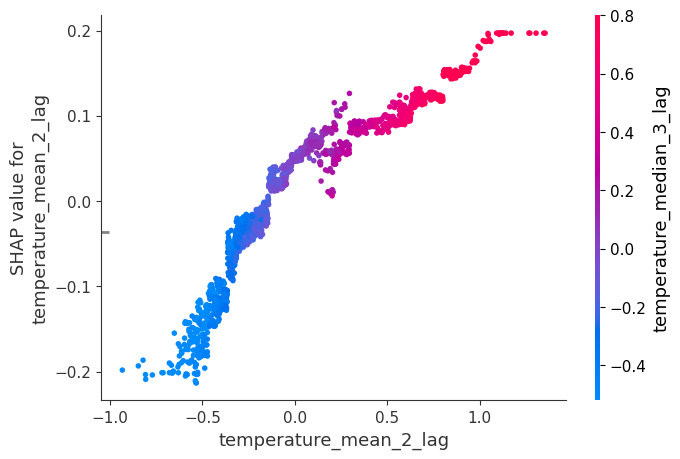

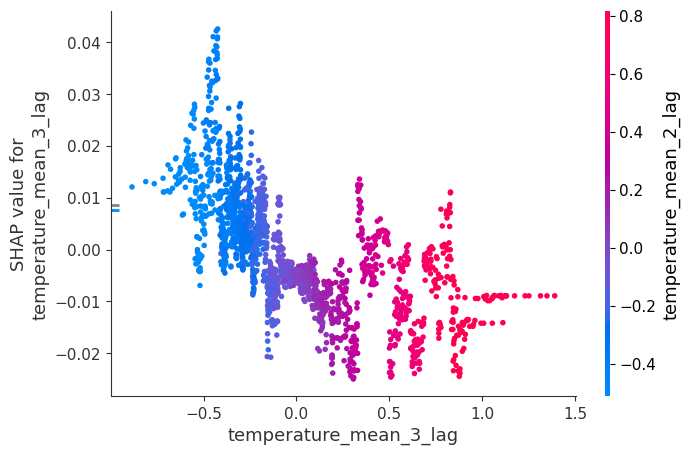

best_feature_model Results


,Dataset,R2,MAE,MAPE,RMSE,Explained Variance
0,Train,0.965235,0.058090,1.153450e+12,0.076537,0.965235
1,Valid,0.920477,0.084742,6.434529e+10,0.114619,0.920687
2,Test,0.911942,0.083496,2.481403e+12,0.114571,0.912021


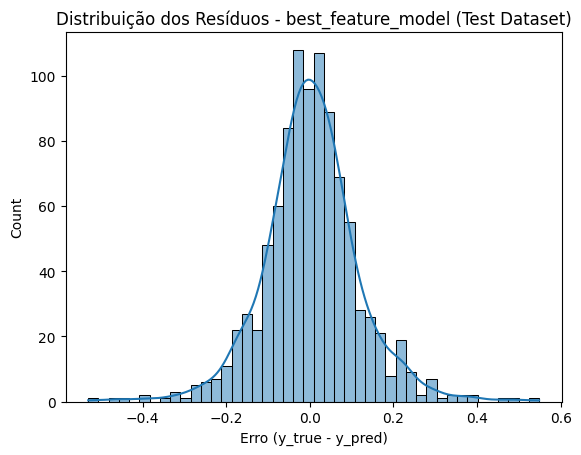

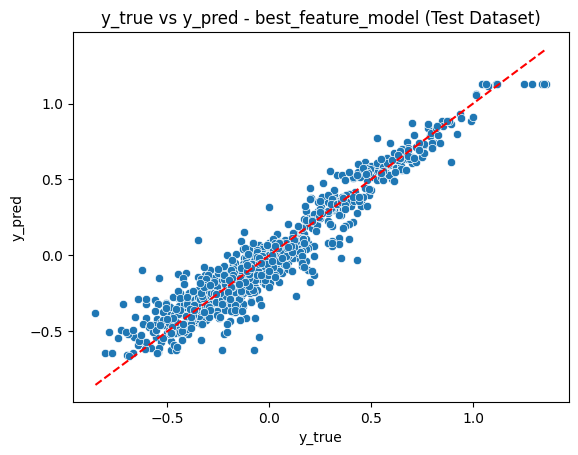

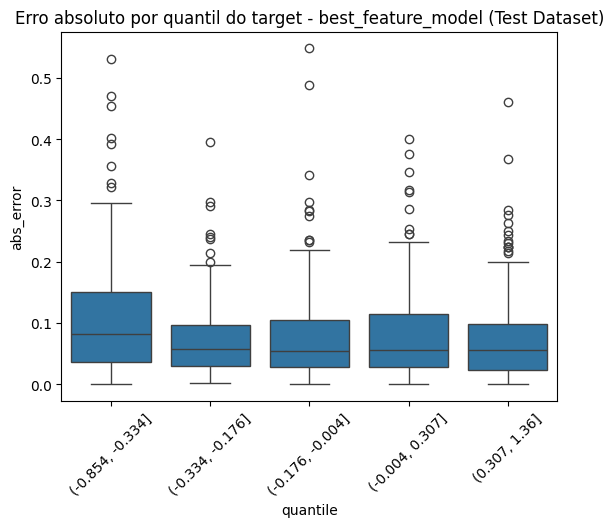

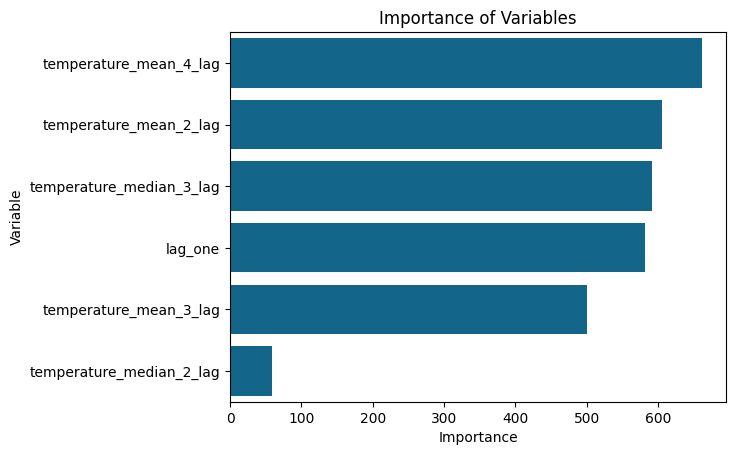

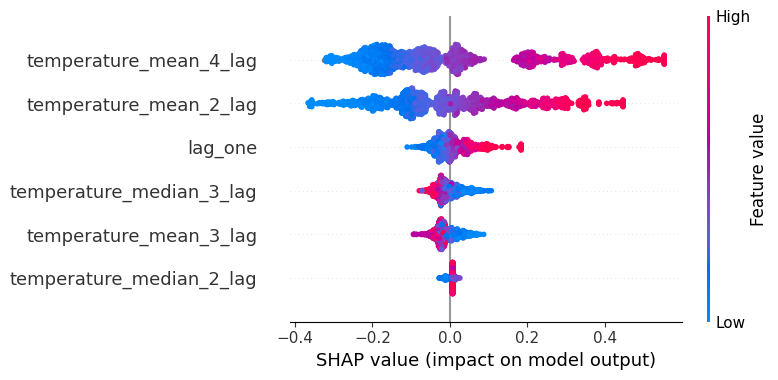

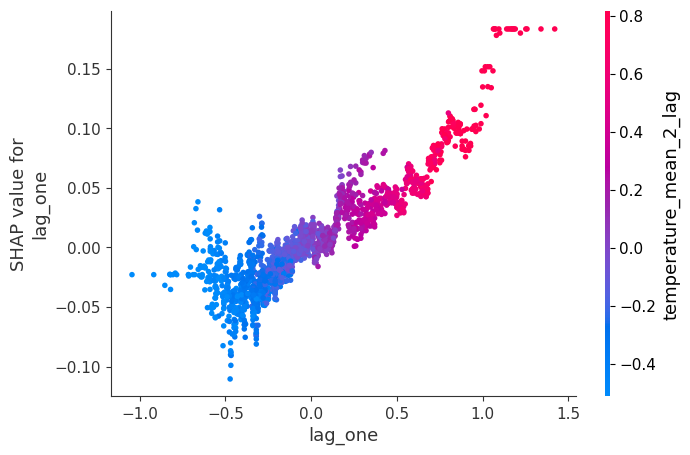

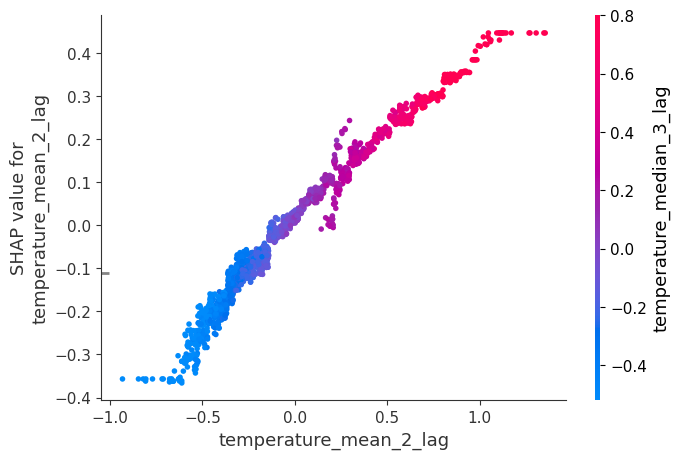

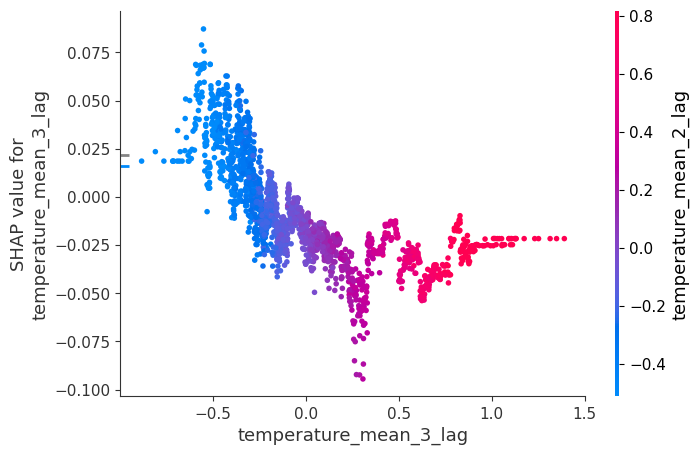

best_params_model Results


,Dataset,R2,MAE,MAPE,RMSE,Explained Variance
0,Train,0.954619,0.066308,1.283719e+12,0.087445,0.954619
1,Valid,0.922221,0.083669,8.700930e+10,0.113356,0.922392
2,Test,0.912281,0.083189,2.484006e+12,0.114350,0.912337


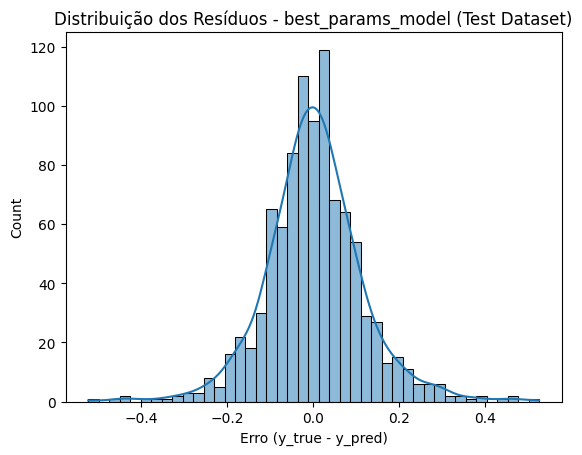

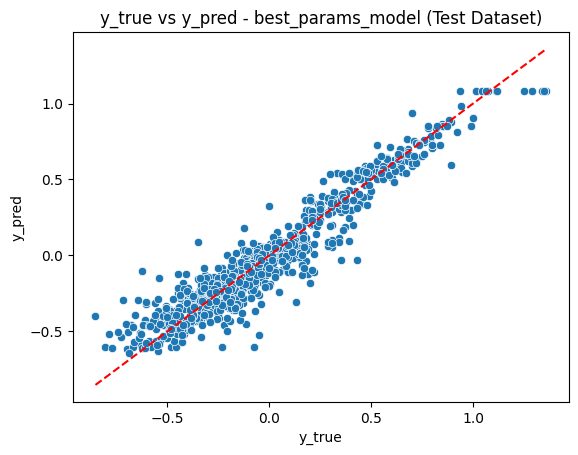

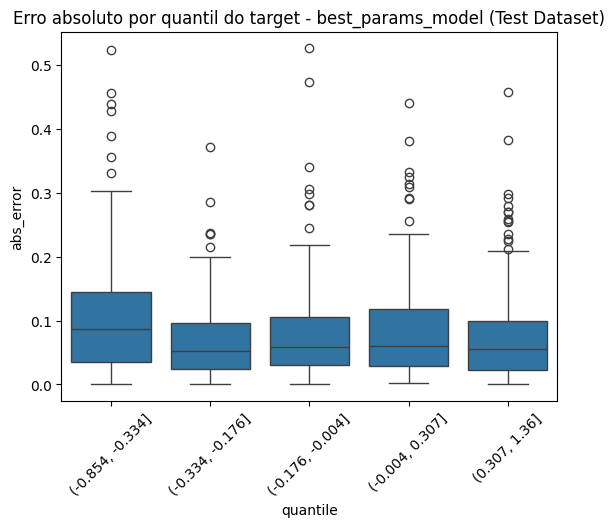

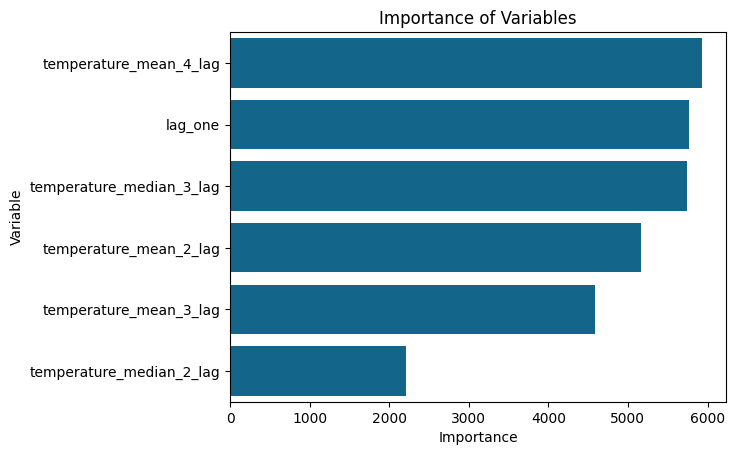

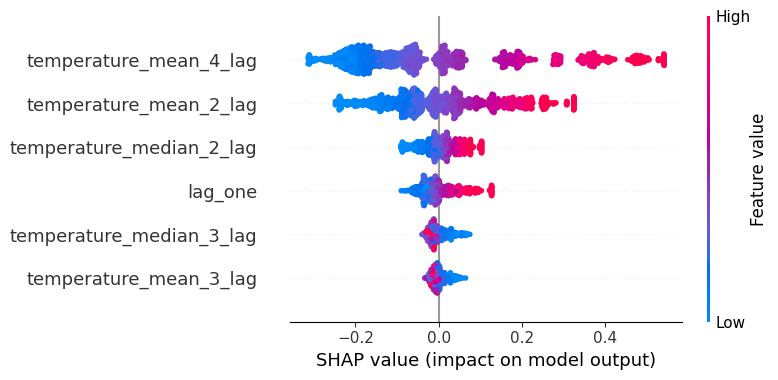

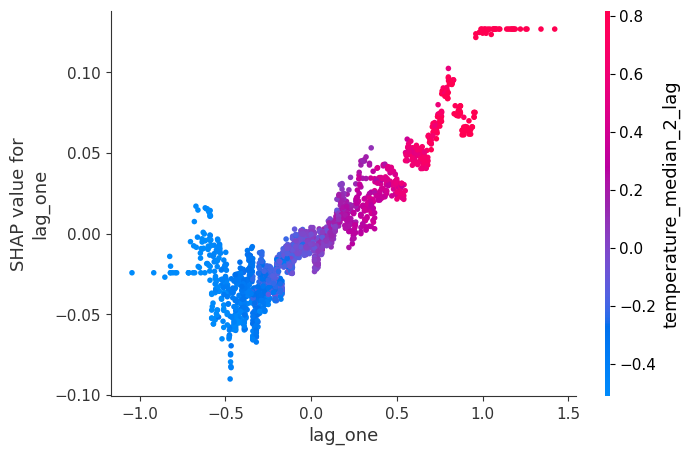

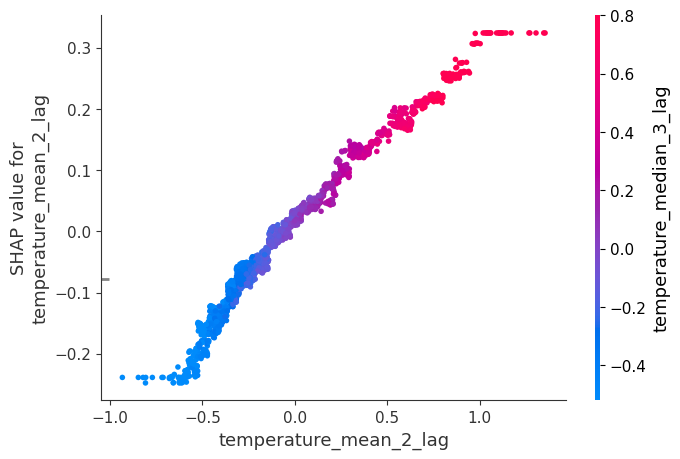

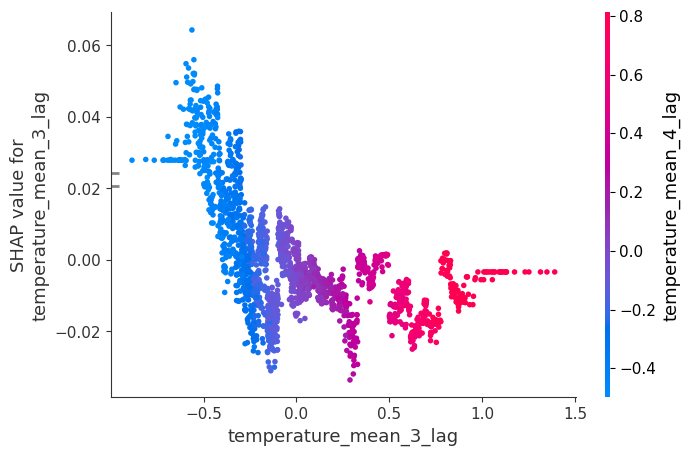

In [21]:
a.get_model_analysis()